In [31]:
from IPython.display import display, Javascript, HTML, Image
import json
import os

In [33]:
def display_vis(file_name):
    display(HTML(filename="../input/vis.html"))
    with open("../input/build_vis.js","r") as vis_file: 
        script_code = vis_file.read()
    script_code+="\ngenerate_vis({})".format(file_name)
    display(Javascript(script_code))

<h1> Overview </h1>

COVID-19 Open Research Dataset (CORD-19) is a open dataset of scientific articles related to the novel COVID-19 virus and available for download online. We present this notebook as to accomplish the following tasks:

<ul>
<li>to retrieve specific, relevant data from a given dataset to answer given questions</li>
<li>to understand and provide access to relationships between articles in the dataset</li>
<li>to construct a robust measurement of success for such a task</li>
</ul>

In order to accomplish the first two tasks, we present three methods of embedding. Our main results are presented with the sciBERT embedding on MeSH keywords. For this embedding method, we create sentence-level embeddings utilizing the sciBERT word embeddings only for the MeSH keywords.

The top three abstracts for answering a given question is shown below with scores:

```
!python search_embeddings.py --embedding_type="MESH" --embeddings_file="abstract_scibert_embeddings.json"
Please enter a statement or question: Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery.

[[0.93065777]]  :  Implications of Host Genetic Variation on the Risk and Prevalence of Infectious Diseases Transmitted Through the Environment Previous studies have shown that host genetic heterogeneity in the response to infectious challenge can affect the emergence risk and the severity of diseases transmitted through direct contact between individuals. However, there is substantial uncertainty about the degree and direction of influence owing to different definitions of genetic variation, most of which are not in line with the current understanding of the genetic architecture of disease traits. Also, the relevance of previous results for diseases transmitted through environmental sources is unclear. In this article a compartmental genetic–epidemiological model was developed to quantify the impact of host genetic diversity on epidemiological characteristics of diseases transmitted through a contaminated environment...

[[0.93211877]]  :  Mathematical prediction in infection Abstract It is now increasingly common for infectious disease epidemics to be analysed with mathematical models. Modelling is possible because epidemics involve relatively simple processes occurring within large populations of individuals. Modelling aims to explain and predict trends in disease incidence, prevalence, morbidity or mortality. Epidemic models give important insight into the development of an epidemic. Following disease establishment, epidemic growth is approximately exponential. The rate of growth in this phase is primarily determined by the basic reproduction number, R 0, the number of secondary cases per primary case when the population is susceptible. R 0 also determines the ease with which control policies can control an epidemic. Once a significant proportion of the population has been infected, not all contacts of an infected individual will be with susceptible people. Infection can now continue only because new births replenish the susceptible population. Eventually an endemic equilibrium is reached where every infected person infects one other individual on average...

[[0.93612156]]  :  Effectiveness of isolation and contact tracing for containment and slowing down a COVID-19 epidemic: a modelling study Background: Novel coronavirus (SARS-CoV-2) is extending its range of transmission in all parts of the world, with substantial variation in rates of transmission and severity of associated disease. Methods: We evaluated whether and under which conditions it is possible to control and slow down a COVID-19 epidemic in the early stages by isolation and contact tracing. We used a stochastic transmission model in which every person generates novel infections according to a probability distribution that is affected by the incubation period distribution (time from infection to symptoms), distribution of the latent period (time from infection to a person becoming infectious), and overall transmissibility. The model distinguishes between close contacts (e.g., within a household) and other contacts in the population. Findings: The analyses showed that transmissibility and the duration of the latent period relative to the duration of incubation period have strong impact on the controllability of the disease. Delays in diagnosis of cases and proportion of asymptomatic cases are key factors for containment and slowing down the epidemic. Interpretation: Isolation and contact tracing can be an effective means to control early epidemics, but only if transmissibility as measured by R0 is in the lower ranges of reported values. Timeliness as well as completeness of tracing and diagnosis of cases are paramount to achieve containment and effective slowing down of the epidemic growth rate.
```

Some of the top words identified in embedding clusters:

```
!python create_embeddings.py --load_file --embeddings_file='abstract_mesh_embeddings.json'


['rna', 'protein', 'virus', 'proteins', 'viral', 'cells', 'replication', 'cell', 'binding', 'coronavirus']
['health', 'disease', 'public', 'data', 'infectious', 'care', 'study', 'diseases', 'risk', 'model']
['pcr', 'detection', 'virus', 'assay', 'samples', 'rt', 'respiratory', 'time', 'viruses', 'viral']
['activity', 'compounds', 'virus', 'antiviral', 'anti', 'compound', 'cell', 'cells', 'inhibitors', 'human']
['patients', 'respiratory', 'infection', 'study', 'ci', 'influenza', 'children', 'cases', 'clinical', '95']
['virus', 'cells', 'infection', 'mice', 'cell', 'protein', 'infected', 'vaccine', 'viral', 'human']
```

<h1> Running from Github </h1>

The full source code for this project can be found on Github. You can run embeddings creation with any of the described embeddings methods by using the create_embeddings.py function under clustering. A sample command is given below. Embeddings creation takes around 15 hours to create for all abstracts. This notebook will only load pre-run embeddings. 

```
!python create_embeddings.py --embedding_type="MESH" --write_file --embeddings_file='abstract_mesh_embeddings.json'
```

<h1> Methodology </h1>

## Constructing SciBERT embeddings filtered by MeSH Keywords

We retrieve preprocessed sentence-level data from the SQLITE database prepared by David Mezzetti (CORD-19 Analysis with Sentence Embeddings). We then filter for MeSH keywords and construct SciBERT section embeddings for the sentences in the abstract. We noticed that many of the Kaggle submissions followed the same system format, in which the text corpus was mapped using an embedding function to some vector in the embedding space. This vector embedding was then used to determine relationships between texts. A given question would then also be mapped through the same function and some similarity metric (euclidean distance, cosine similarity, etc.) would then be used to determine most similar texts. A diagram of such a system is given below where the red dot represents the question embedding in the space:


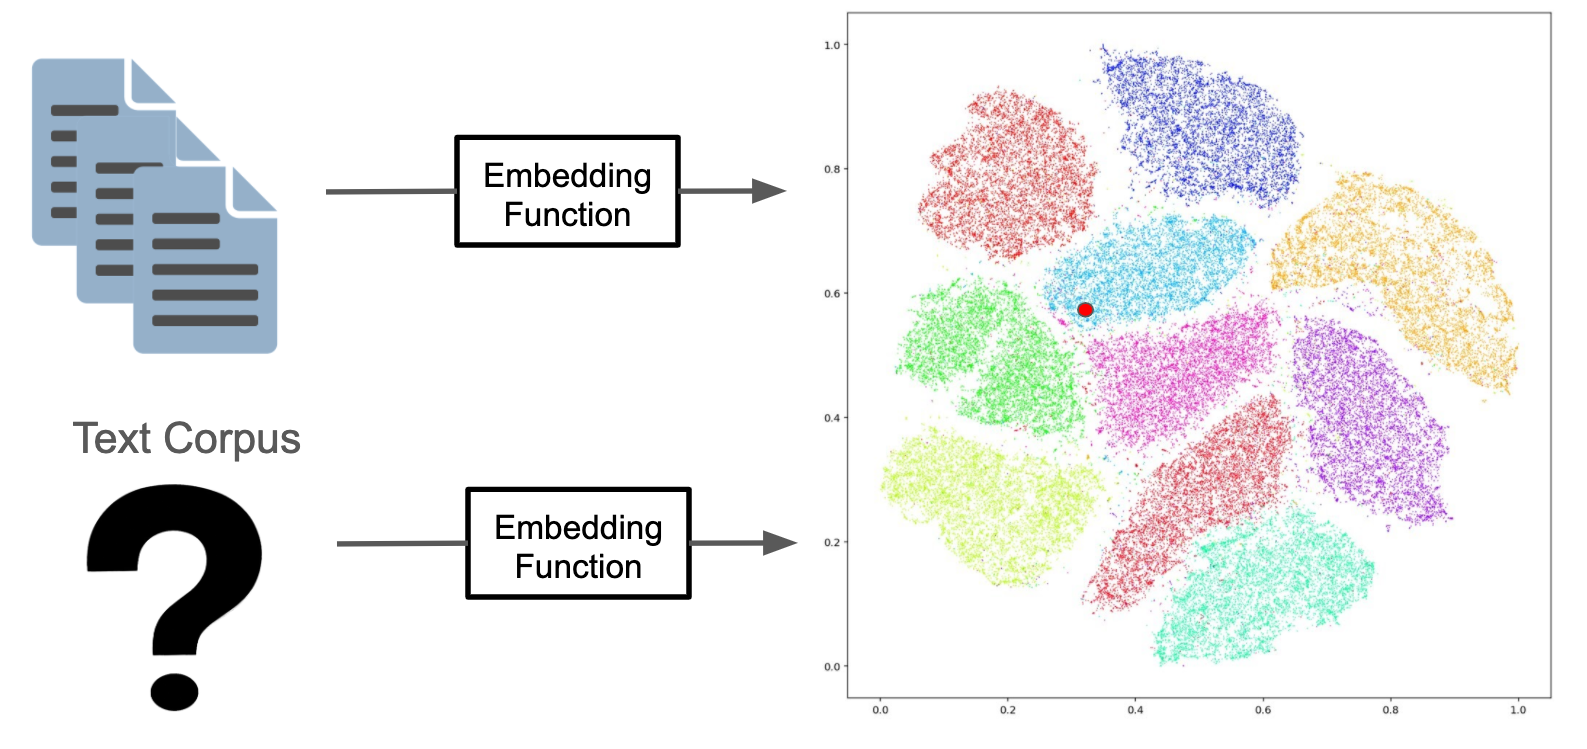

In [18]:
Image("../input/system.png")

Thus, we designed our system such that it can be run with any embedding function that maps lists of lists of sentences to vectors. We tested three variations of embedding functions for comparison. The steps for constructing our SciBERT embeddings filtered by MeSH keywords is given below.

<ol>
    <li> Break title + abstract into sentences </li>
    <li> Retrieve sciBERT representation of each sentence, weight tokens by 0 if not in MeSH keywords, 1 if in </li>
    <li> Average sentence embeddings to return paragraph embedding </li>
</ol>

We designed our system to evaluate on the paragraph/abstract level because we found paragraphs to be a natural division in papers based on topic. We run our embeddings on abstracts only here due to training time constraints. We expect this model to work similarly for sections for entire texts.

## Visualizing clusters

We visualize clusters in two different ways. First, we use TSNE or PCA to project the embedding space into two dimensions. We then use k-means clustering with a set number of clusters to determine cluster labels. Next, we determine the top 10 words from each cluster that are not stop-words ranked by TF-IDF. 


## Querying the dataset

Given an embedding file, we construct a search by taking a statement or question and constructing an embedding using the same model and then finding the nearest abstracts ranked by cosine similarity to the given question or statement embedding. An example search command is given below:

```
!python search_embeddings.py --embeddings_file="abstract_scibert_embeddings.json"
```


<h1> Results </h1>

## Search Results

Some example queries and results are given below. The queries were taken to be similar to current top Kaggle submissions and tasks:

```
python search_embeddings.py --embedding_type="MESH" --embeddings_file="abstract_mesh_embeddings.json"

Please enter a statement or question: How does the incubation period varies across age and health status?

[[0.77083886]]  :  Realized generation times: contraction and impact of infectious period, reproduction number and population size AbstractOne of the key characteristics of the transmission dynamics of infectious diseases is the generation time which refers to the time interval between the infection of a secondary case and the infection of its infector. The generation time distribution together with the reproduction number determines the rate at which an infection spreads in a population. When defining the generation time distribution at a calendar time t two definitions are plausible according whether we regard t as the infection time of the infector or the infection time of the infectee...

[[0.77261049]]  :  Provincial income inequality and self‐reported health status in China during 1991–7 BACKGROUND: The relationship between income inequality and health has been widely explored. Today there is some evidence suggesting that good health is inversely related to income inequality. After the economic reforms initiated in the early 1980s, China experienced one of the fastest‐growing income inequalities in the world. The state of China in the 1990s is focussed on and possible effects of provincial income inequality on individual health status are explored. METHODS: A multilevel regression model is used to analyse the data collected in 1991, 1993 and 1997 from nine provinces included in the China Health and Nutrition Survey. The effects of provincial Gini coefficients on self‐rated health in each year are evaluated by two logistic regressions estimating the odds ratios of reporting poor or fair health...

[[0.77326321]]  :  Applying the balanced scorecard to local public health performance measurement: deliberations and decisions BACKGROUND: All aspects of the heath care sector are being asked to account for their performance. This poses unique challenges for local public health units with their traditional focus on population health and their emphasis on disease prevention, health promotion and protection. Reliance on measures of health status provides an imprecise and partial picture of the performance of a health unit. In 2004 the provincial Institute for Clinical Evaluative Sciences based in Ontario, Canada introduced a public-health specific balanced scorecard framework. We present the conceptual deliberations and decisions undertaken by a health unit while adopting the framework...

[[0.78694074]]  :  Determining the dynamics of influenza transmission by age BACKGROUND: It is widely accepted that influenza transmission dynamics vary by age; however methods to quantify the reproductive number by age group are limited. We introduce a simple method to estimate the reproductive number by modifying the method originally proposed by Wallinga and Teunis and using existing information on contact patterns between age groups. We additionally perform a sensitivity analysis to determine the potential impact of differential healthcare seeking patterns by age. We illustrate this method using data from the 2009 H1N1 Influenza pandemic in Gauteng Province, South Africa. RESULTS: Our results are consistent with others in showing decreased transmission with age. We show that results can change markedly when we make the account for differential healthcare seeking behaviors by age. CONCLUSIONS: We show substantial heterogeneity in transmission by age group during the Influenza A H1N1 pandemic in South Africa. This information can greatly assist in targeting interventions and implementing social distancing measures.

[[0.79083895]]  :  What Effect Did the Global Financial Crisis Have Upon Youth Wellbeing? Recent research has suggested significant negative effects of the Global Financial Crisis (GFC) on mental health and wellbeing. In this article, the authors suggest that the developmental period of late adolescence may be at particular risk of economic downturns. Harmonizing 4 longitudinal cohorts of Australian youth (N = 38,017), we estimate the impact of the GFC on 1 general and 11 domain specific measures of wellbeing at age 19 and 22. Significant differences in wellbeing in most life domains were found, suggesting that wellbeing is susceptible to economic shocks. Given that the GFC in Australia was relatively mild, the finding of clear negative effects across 2 ages is of international concern.
```

```
python search_embeddings.py --embedding_type="MESH" --embeddings_file="abstract_mesh_embeddings.json"

Please enter a statement or question: Tools and studies to monitor phenotypic change and potential adaptation of the virus

[[0.84317189]]  :  Comparative Serological Assays for the Study of H5 and H7 Avian Influenza Viruses The nature of influenza virus to randomly mutate and evolve into new types is an important challenge in the control of influenza infection. It is necessary to monitor virus evolution for a better understanding of the pandemic risk posed by certain variants as evidenced by the highly pathogenic avian influenza (HPAI) viruses...

[[0.84452347]]  :  A double epidemic model for the SARS propagation BACKGROUND: An epidemic of a Severe Acute Respiratory Syndrome (SARS) caused by a new coronavirus has spread from the Guangdong province to the rest of China and to the world, with a puzzling contagion behavior. It is important both for predicting the future of the present outbreak and for implementing effective prophylactic measures, to identify the causes of this behavior. RESULTS: In this report, we show first that the standard Susceptible-Infected-Removed (SIR) model cannot account for the patterns observed in various regions where the disease spread. We develop a model involving two superimposed epidemics to study the recent spread of the SARS in Hong Kong and in the region. We explore the situation where these epidemics may be caused either by a virus and one or several mutants that changed its tropism, or by two unrelated viruses...

[[0.84501396]]  :  Microarray-based identification of antigenic variants of foot-and-mouth disease virus: a bioinformatics quality assessment BACKGROUND: The evolution of viral quasispecies can influence viral pathogenesis and the response to antiviral treatments. Mutant clouds in infected organisms represent the first stage in the genetic and antigenic diversification of RNA viruses, such as foot and mouth disease virus (FMDV), an important animal pathogen. Antigenic variants of FMDV have been classically diagnosed by immunological or RT-PCR-based methods. DNA microarrays are becoming increasingly useful for the analysis of gene expression and single nucleotide polymorphisms (SNPs)...

[[0.84576412]]  :  Molecular Biology of Bovine Viral Diarrhea Virus and its Interactions with the Host The contributions of pestivirus molecular biology research to our understanding of Bovine Viral Diarrhea Virus (BVDV) biology and disease have been remarkable. Completion of nucleotide sequence information for genomes of NCP and CP-BVDV isolates was an important milestone. Subsequent work on the protein map of BVDV and polyprotein processing pathways paved the way for the interpretation of many other virologic and immunologic studies. Discovery of a correlation between genotype II and virulence (hemorrhagic syndrome) will help to clarify previously controversial data and to improve disease control...

[[0.84601302]]  :  Isolation of Virus from a SARS Patient and Genome-wide Analysis of Genetic Mutations Related to Pathogenesis and Epidemiology from 47 SARS-CoV Isolates Severe acute respiratory syndrome (SARS) caused by SARS-associated coronavirus (SARS-CoV) is a fatal disease. Prevention of future outbreaks is essential and requires understanding pathogenesis and evolution of the virus. We have isolated a SARS-CoV in China and analyzed 47 SARS-CoV genomes with the aims to reveal the evolution trends of the virus and provide insights into understanding pathogenesis and SARS epidemic...
```

```
python search_embeddings.py --embedding_type="MESH" --embeddings_file="abstract_mesh_embeddings.json"

Please enter a statement or question: What are potential drug therapies of coronaviruses?

[[0.71959323]]  :  Current status of treatment for 2019 novel coronavirus pneumonia 2019 novel coronavirus (2019-nCoV) is a new member of coronavirus family that can cause serious respiratory diseases after the emergence of severe acute respiratory syndrome-coronavirus (SARS-CoV) and middle east respiratory syndrome-coronavirus (MERS-CoV). At present, there is no specific antiviral drug targeting 2019-nCoV. In facing of the increasingly serious epidemic of 2019 novel coronavirus pneumonia and the urgent needs in drug treatment strategies, this paper reviewed the current research situation and progress in antiviral treatment for the newly identified disease.

[[0.72071041]]  :  Flavonoids as Antiviral Agents for Enterovirus A71 (EV-A71) Flavonoids are natural biomolecules that are known to be effective antivirals. These biomolecules can act at different stages of viral infection, particularly at the molecular level to inhibit viral growth. Enterovirus A71 (EV-A71), a non-enveloped RNA virus, is one of the causative agents of hand, foot and mouth disease (HFMD), which is prevalent in Asia. Despite much effort, no clinically approved antiviral treatment is available for children suffering from HFMD. Flavonoids from plants serve as a vast reservoir of therapeutically active constituents that have been explored as potential antiviral candidates against RNA and DNA viruses. Here, we reviewed flavonoids as evidence-based natural sources of antivirals against non-picornaviruses and picornaviruses. The detailed molecular mechanisms involved in the inhibition of EV-A71 infections are discussed.

[[0.72264115]]  :  Management and clinical thinking of Coronavirus Disease 2019 In December 2019, the 2019 novel coronavirus pneumonia (NCP, officially named Coronavirus Disease 2019(COVID-19) by the World Health Organization) broke out in Wuhan, Hubei, and it quickly spread to the whole country and abroad. The situation was at stake. The sudden and serious COVID-19 epidemic has brought us a lot of urgent problems. How to effectively control the spread of COVID-19? When does the population infection rate rise to its peak? What will eventually be the number of infected patients? How to make early diagnosis? What effective antiviral drugs are available? How to effectively treat with existing drugs? Can it successfully improve the survival rate of critically patients? In response to the above questions, we put forward corresponding suggestions and reflections from the perspective of the infectious clinician.

[[0.72493623]]  :  Perspectives on therapeutic neutralizing antibodies against the Novel Coronavirus SARS-CoV-2 A newly identified novel coronavirus (SARS-CoV-2) is causing pneumonia-associated respiratory syndrome across the world. Epidemiology, genomics, and pathogenesis of the SARS-CoV-2 show high homology with that of SARS-CoV. Current efforts are focusing on development of specific antiviral drugs. Therapeutic neutralizing antibodies (NAbs) against SARS-CoV-2 will be greatly important therapeutic agents for the treatment of coronavirus disease 2019 (COVID-19). Herein, the host immune responses against SARS-CoV discussed in this review provide implications for developing NAbs and understanding clinical interventions against SARS-CoV-2. Further, we describe the benefits, challenges and considerations of NAbs against SARS-CoV-2. Although many challenges exist, NAbs still offer a therapeutic option to control the current pandemic and the possible re-emergence of the virus in the future, and their development therefore remains a high priority.

[[0.72769375]]  :  Prediction of antiviral drugs against African Swine Fever Viruses based on protein-protein interaction analysis AbstractThe African swine fever virus (ASFV) has severely influenced the swine industry of the world. Unfortunately, there is no effective antiviral drug or vaccine against the virus until now. Identification of new anti-ASFV drugs is urgently needed. Here, an up-to-date set of protein-protein interactions (PPIs) between ASFV and swine were curated by integration of PPIs from multiple sources. Thirty-two swine proteins were observed to interact with ASFVs and were defined as AIPs. They were found to play a central role in the swine PPI network, with significant larger degree, betweenness and smaller shortest path length than other swine proteins. Some of AIPs also interacted with several other viruses and could be taken as potential targets of drugs for broad-spectrum effect, such as HSP90AB1. Finally, the antiviral drugs which targeted AIPs and ASFV proteins were predicted. Several drugs with either broad-spectrum effect or high specificity on AIPs were identified, such as Polaprezinc. This work could not only deepen our understanding towards the ASFV-swine interactions, but also help for the development of effective antiviral drugs against the ASFVs.
```

The code and our pretrained embeddings are available on our GitHub repository for users to try themselves. The search functionality is easily accessible from the command line. Generally, these example papers do seem relevant to the given questions.


## Clustering Results

```
7 clusters found

['respiratory', 'cov', 'infection', 'coronavirus', 'human', 'samples', 'pcr', 'influenza', 'sars', 'detection']

['host', 'human', 'new', 'infection', 'based', 'development', 'rna', 'immune', 'may', 'review']

['patients', 'respiratory', 'infection', 'study', 'clinical', 'influenza', 'children', 'cases', 'infections', 'results']

['infecciones', 'tratamiento', 'infections', 'chez', 'résumé', 'pacientes', 'cas', 'respiratory', 'respiratorias', 'vrs']

['rna', 'binding', 'fusion', 'replication', 'cov', 'coronavirus', 'sars', 'activity', 'membrane', 'domain']

['infection', 'ifn', 'mice', 'expression', 'immune', 'induced', 'infected', 'response', 'human', 'replication']

['health', 'public', 'data', 'infectious', 'study', 'outbreak', 'epidemic', 'control', 'transmission', 'influenza']
```

In [32]:
from IPython.core.display import display, HTML, Javascript
import IPython.display

h = display(HTML("../input/vis.html"))
j = IPython.display.Javascript("../input/build_vis.js")
IPython.display.display_javascript(j)

In [36]:
display(HTML(filename="../input/vis.html"))
with open("../input/build_vis.js","r") as vis_file: 
    script_code = vis_file.read()
script_code+="\ngenerate_vis({})".format("'../input/EMBEDDINGS_PROCESSED_MESH'")
display(Javascript(script_code))

<IPython.core.display.Javascript object>

In [23]:
display_vis("'../input/EMBEDDINGS_PROCESSED_MESH'")

<IPython.core.display.Javascript object>

<h1> Evaluation </h1>

One aspect of this task that we think has been overlooked is an evaluation method for embedding spaces. As these papers are not annotated, evaluating metrics are not straightforward. In this section, we brainstorm some potential evaluation metrics for document embedding spaces. Hopefully, we will be able to implement some of these in a later iteration of the project.

## Cluster cohesion

Some previous submissions present cluster cohesion as a potential method for identifying distinct topics within the embedding space. We present the cluster cohesion metrics for the three embedding spaces tested in this submission. The silhouette score is calculated using two metrics: a (the mean intra-cluster distance) and b (the mean nearest-cluster distance). The silhouette score is then defined as (b-a)/max(a, b). Silhouette scores define how well-defined clusters are. For a random sample of 5000 embeddings, we compute the silhouette scores for our three embedding spaces for 10 clusters.

```
SciBERT + MeSH: 0.0747

SciBERT: 0.0882

SciBERT + TFIDF: 
```

However, since the embeddings are of such large dimension, it is difficult to discern true differences between embedding spaces. Futhermore, since papers can be of multiple topics and this is not a classification task, cluster cohesion does not necessary determine directly better embedding spaces.

## Performance on related tasks

### Information retrieval

Alternatively, our search mechanism is essentially a question retrieval task. Consequently, there are other question/retrieval datasets that have been annotated. One example of this is the [TyDi annotated dataset](https://github.com/google-research-datasets/tydiqa) constructed by Google AI. However, some embedding methods, such as our SciBERT and MeSH weighted embedding method was constructed particularly for this scientific task. This might decrease performance on other question retrieval tasks.

### Identifying misinformation

Another idea that we came up with is to determine a misinformation dataset that could be annotated by users. This would also be useful in identifying misinformation in the press or in other sources of news. We expect true information to be more supported in the dataset. Thus, we can test true and untrue statements by looking at the average of the top five scores in the dataset. One example of this is given below for abstact SciBERT and MeSH embeddings:

```
Statement: Coronavirus can lead to pneumonia.

Score: 0.81
```

```
Statement: Coronavirus does not lead to pneumonia.

Score: 0.75
```

By annotating a set of statements as more true or less true using input by knowledgeable humans, we may also be able to give a soft ranking for better and worse embedding spaces. Such a system would also be useful in identifying and possibly correcting misinformation and rating news.


<h1> Appendix </h1>

Alternative embedding methods and results are shown here. To save space and because the full search engine is available online, we only provide one search example per embedding method.

## SciBERT embeddings

### Embedding Methodology

<ol>
    <li> Break title + abstract into sentences </li>
    <li> Retrieve sciBERT representation of each sentence </li>
    <li> Average sentence embeddings to return paragraph embedding </li>
</ol>

### Search Results

```
python search_embeddings.py --embedding_type="SCIBERT" --embeddings_file="abstract_scibert_embeddings.json"

Please enter a statement or question: What are potential drug therapies of coronaviruses?

[[0.80523918]]  :  How Coronaviruses Cause Infection—from Colds to Deadly Pneumonia The novel coronavirus outbreak raises questions about how such pathogens evolve and what makes infections mild or severe

[[0.81030157]]  :  Tough challenges for testing Ebola therapeutics Therapies for Ebola virus disease are urgently needed, but they must be rigorously tested for safety and efficacy before any mass roll-out to patients. Fiona Fleck reports.

[[0.81636066]]  :  Shifting emphasis from pharmacogenomics to theragnostics What will be the role of theragnostic patents in upstream and downstream biomarker research?

[[0.81762626]]  :  Management and clinical thinking of Coronavirus Disease 2019 In December 2019, the 2019 novel coronavirus pneumonia (NCP, officially named Coronavirus Disease 2019(COVID-19) by the World Health Organization) broke out in Wuhan, Hubei, and it quickly spread to the whole country and abroad. The situation was at stake. The sudden and serious COVID-19 epidemic has brought us a lot of urgent problems. How to effectively control the spread of COVID-19? When does the population infection rate rise to its peak? What will eventually be the number of infected patients? How to make early diagnosis? What effective antiviral drugs are available? How to effectively treat with existing drugs? Can it successfully improve the survival rate of critically patients? In response to the above questions, we put forward corresponding suggestions and reflections from the perspective of the infectious clinician.

[[0.82946845]]  :  The hunt for covid-19 drugs Many drugs and vaccines are now being developed and tested
```

### Clustering Results

```
6 clusters found

['rna', 'binding', 'coronavirus', 'replication', 'infection', 'cov', 'sars', 'sequence', 'membrane', 'golgi']

['health', 'public', 'infectious', 'data', 'epidemic', 'model', 'control', 'outbreak', 'china', 'transmission']

['infection', 'mice', 'expression', 'ifn', 'induced', 'immune', 'infected', 'human', 'specific', 'results']

['patients', 'respiratory', 'study', 'infection', 'influenza', 'cases', 'children', 'results', 'clinical', '95']

['respiratory', 'infection', 'pcr', 'cov', 'coronavirus', 'human', 'samples', 'detection', 'sars', 'assay']

['host', 'infection', 'immune', 'human', 'based', 'rna', 'review', 'new', 'clinical', 'development']

['patients', 'infection', 'infecciones', 'chez', 'infections', 'diagnóstico', 'risque', 'respiratoire', 'resumen', 'résumé']
```


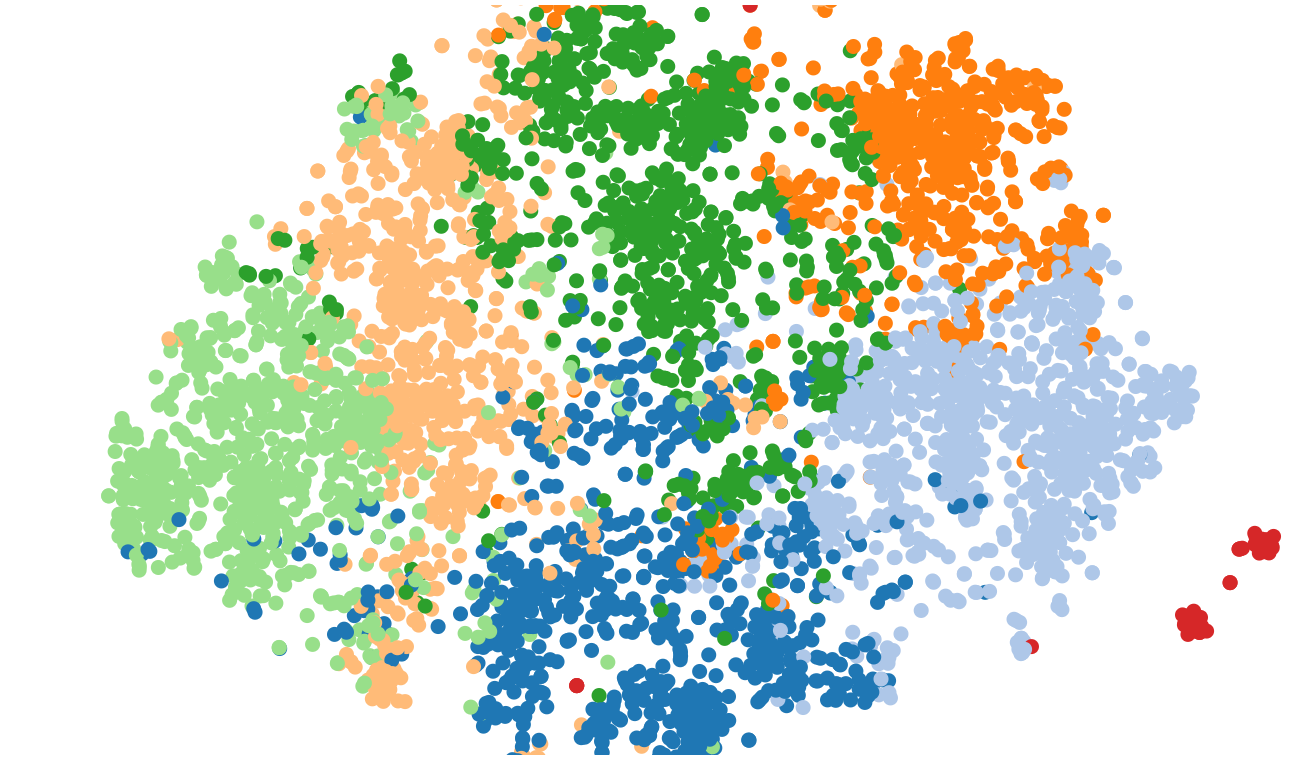

In [16]:
Image("../input/SCIBERT.png")

## TFIDF weighted SciBERT embeddings

### Embedding Methodology

<ol>
    <li> Break title + abstract into sentences </li>
    <li> Retrieve sciBERT representation of each sentence, weight tokens by TF-IDF scores across the entire corpus</li>
    <li> Average sentence embeddings to return paragraph embedding </li>
</ol>

### Search Results

```
python search_embeddings.py --embedding_type="SCIBERT_TFIDF" --embeddings_file="abstract_scibert_tfidf_embeddings.json"

Please enter a statement or question: What are potential drug therapies of coronaviruses?

[[0.6976624]]  :  Coronaviruses — drug discovery and therapeutic options In humans, infections with the human coronavirus (HCoV) strains HCoV-229E, HCoV-OC43, HCoV-NL63 and HCoV-HKU1 usually result in mild, self-limiting upper respiratory tract infections, such as the common cold. By contrast, the CoVs responsible for severe acute respiratory syndrome (SARS) and Middle East respiratory syndrome (MERS), which were discovered in Hong Kong, China, in 2003, and in Saudi Arabia in 2012, respectively, have received global attention over the past 12 years owing to their ability to cause community and health-care-associated outbreaks of severe infections in human populations. These two viruses pose major challenges to clinical management because there are no specific antiviral drugs available. In this Review, we summarize the epidemiology, virology, clinical features and current treatment strategies of SARS and MERS, and discuss the discovery and development of new virus-based and host-based therapeutic options for CoV infections. 

[[0.70208923]]  :  A review of candidate therapies for Middle East respiratory syndrome from a molecular perspective There have been 2040 laboratory-confirmed cases of Middle East respiratory syndrome coronavirus (MERS-CoV) in 27 countries, with a mortality rate of 34.9 %. There is no specific therapy. The current therapies have mainly been adapted from severe acute respiratory syndrome (SARS-CoV) treatments, including broad-spectrum antibiotics, corticosteroids, interferons, ribavirin, lopinavir–ritonavir or mycophenolate mofetil, and have not been subject to well-organized clinical trials. The development of specific therapies and vaccines is therefore urgently required. We examine existing and potential therapies and vaccines from a molecular perspective. These include viral S protein targeting; inhibitors of host proteases, including TMPRSS2, cathepsin L and furin protease, and of viral M(pro) and the PL(pro) proteases...

[[0.70639185]]  :  Potential therapies for coronaviruses Coronavirus replication offers several attractive targets for chemotherapy. These include: viral entry (inhibited by chloroquine and peptides); viral RNA (targeted by antisense approaches/RNAi); the main protease 3CLpro (inhibited by peptidic molecules such as HIV-1 protease inhibitors and miscellaneous compounds); the accessory protease(s) PLpro(s) (inhibited by zinc ions); RNA-dependent RNA polymerase (inhibited by aurintricarboxylic acid and antisense approaches); and helicase (inhibited by bananins). Chloroquine and HIV-1 protease inhibitors (with well-known toxicity profiles) should be considered for clinical tests if severe acute respiratory syndrome (SARS) re-emerges; however, there are other attractive compounds. Lessons should be learnt from AIDS research for choosing the best strategies.

[[0.70839219]]  :  Advance in human coronaviruses research of host interactions 2019-novel coronavirus (2019-nCoV) is a highly pathogenic human CoV that first emerged in Wuhan in 2019.2019-nCoV has a zoonotic origin and poses a major threat to public health.However, little is known about the viral factors contributing to the high virulence of 2019-nCoV.Many animal viruses, including CoVs, encode proteins that interfere with host gene expression, including those involved in antiviral immune responses, and these viral proteins are often major virulence factors... This review discuss various host physiopathologic mechanism, such as apoptosis, innate immunity, endoplasmic reticulum (ER) stress response, mitogen-activated protein kinase (MAPK) pathway and nuclear factor kappa B (NF-&kappa;B) pathway that may be modulated by HCoVs and provides evidence for the intensive investigate of 2019-nCoV infection.

[[0.71888477]]  :  Management and clinical thinking of Coronavirus Disease 2019 In December 2019, the 2019 novel coronavirus pneumonia (NCP, officially named Coronavirus Disease 2019(COVID-19) by the World Health Organization) broke out in Wuhan, Hubei, and it quickly spread to the whole country and abroad. The situation was at stake. The sudden and serious COVID-19 epidemic has brought us a lot of urgent problems. How to effectively control the spread of COVID-19? When does the population infection rate rise to its peak? What will eventually be the number of infected patients? How to make early diagnosis? What effective antiviral drugs are available? How to effectively treat with existing drugs? Can it successfully improve the survival rate of critically patients? In response to the above questions, we put forward corresponding suggestions and reflections from the perspective of the infectious clinician.
```

### Clustering Results


```
7 clusters found

['patients', 'respiratory', 'infection', 'influenza', 'study', 'children', 'clinical', 'pneumonia', 'acute', 'infections']

['rna', 'replication', 'binding', 'coronavirus', 'infection', 'gene', 'fusion', 'two', 'membrane', 'domain']

['human', 'based', 'using', 'detection', 'new', 'used', 'development', 'rna', 'antiviral', 'host']

['infection', 'cov', 'coronavirus', 'human', 'respiratory', 'sars', 'study', 'pedv', 'samples', 'vaccine']

['infection', 'mice', 'immune', 'ifn', 'expression', 'induced', 'response', 'human', 'infected', 'responses']

['unknown', 'appendix', '978', 'abbreviations', 'radiologiques', 'breastfeeding', 'sras', 'virology', 'precautions', 'press']

['health', 'data', 'public', 'infectious', 'influenza', 'transmission', 'outbreak', 'control', 'study', '19']
```

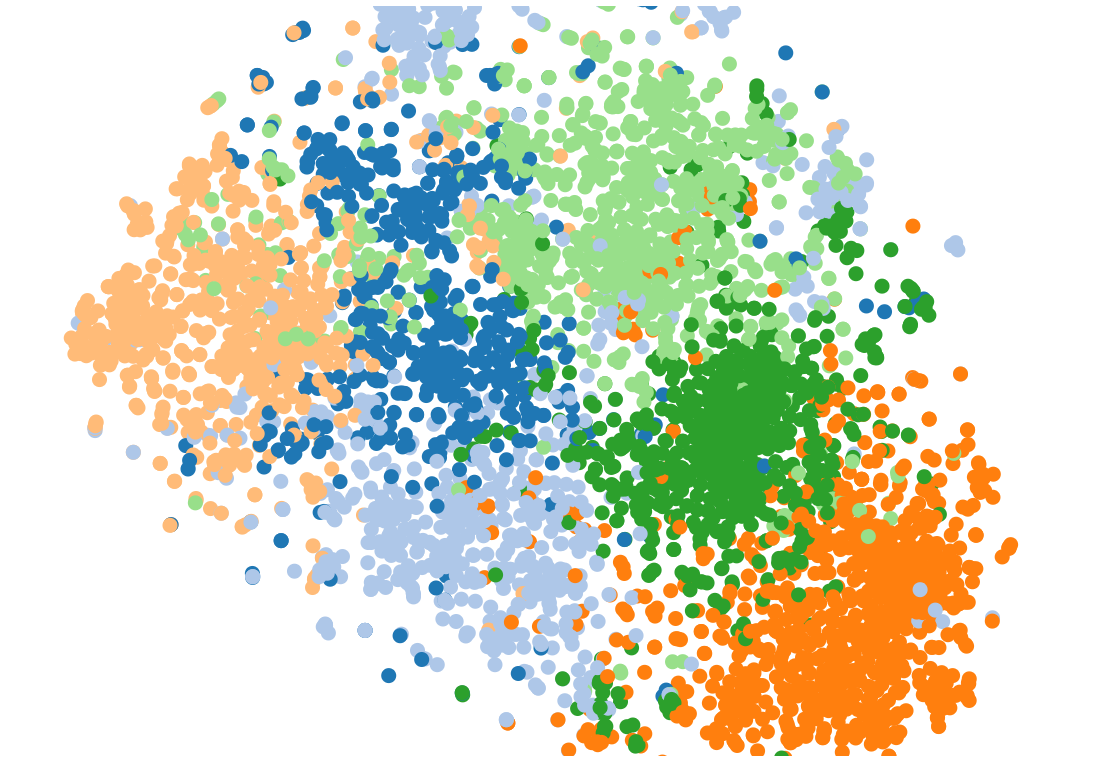

In [19]:
Image("../input/SCIBERT_TFIDF.png")

## Ideas/Discussion for the Community
<ol>
    <li> Insight from conversations with doctors/biomedical researchers in Chennai: researchers were keen on a scientific research search tool that operated on a granularity much finer than the level of document. Many researchers noted that being able to query the top K documents based upon a given keyword might not be useful for most use cases. Researchers noted pain points in needing to skim research papers that could be 50+ pages for a few small portions of information. These conversations inspired us to create search functionality that could retrieve relevant information on a paragraph granularity. We are thankful to the team at the Allen Institute of Artificial Intelligence for providing an open-source pretrained sciBERT model to the research community. It seems as though one of the desired features for biomedical researchers in particular was in the realm of extractive summarization (i.e being able to pull out the K most relevant sentences from a document conditioned upon a query). Our team noted that there do not exist strong open-sourced pretrained models for extractive embeddings that are well tailored to scientific text, and believe that work on this could greatly augment the utility of query tools like ours.</li>
    <li> Task relevant insight from our work: in the above embeddings constructed using abstracts, we see that there exists cohesion between documents that discuss semantically similar ideas. From our knowledge of scientific writing, we know that each paragraph in a given research paper contains different values of information. We may be able to leverage this in future work to augment our tool. For example, consider two papers that are nearly identical that are testing two distinct treatments for COVID-19. Even if there exists a lot of information overlap in some sections of the paper (like related work), other portions of the paper (like methods) could provide more value of information for discriminating between the two articles with a fine granularity. </li>
</ol>